# Tutorial em Tensorflow: Regressão Linear

Nesse tutorial vamos montar um modelo de regressão linear usando a biblioteca [Tensorflow](https://www.tensorflow.org/).

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import util
%matplotlib inline

Vamos usar um dataset bem simples: [Fire and Theft in Chicago](http://college.cengage.com/mathematics/brase/understandable_statistics/7e/students/datasets/slr/frames/frame.html)

As obervações são pares $(X,Y)$ em que

- $X =$ incêncios por 1000 moradías
- $Y =$ roubos por 1000 habitantes

referentes a cidade de Chicago.

In [2]:
# Podemos olhar o começo dessa tabela
df = pd.read_excel('data/fire_theft.xls')
df.head()

X   Y
0   6.2  29
1   9.5  44
2  10.5  36
3   7.7  37
4   8.6  53

In [3]:
# E também podemos ver algumas estatísticas descritivas básicas
df.describe()

X           Y
count  42.000000   42.000000
mean   12.692857   33.666667
std     9.667683   23.040438
min     2.000000    4.000000
25%     5.625000   22.000000
50%    10.500000   31.000000
75%    17.175000   39.750000
max    39.700000  147.000000

In [4]:
#transformando o dataset numa matrix
data = df.as_matrix()
data = data.astype('float32')

## Antes de montar o modelo vamos definir todos os **Hyper parametros**

In [5]:
num_samples = data.shape[0]
learning_rate=0.001
num_epochs=101
show_epoch=10

### Graph e Session são duas classes centrais no tensorflow.

Nós montamos as operações na classe Graph (o grafo de computação) e executamos essas operações dentro de uma Session.

- Sempre existe um grafo default.

- Quando usamos tf.Graph.as_default sobrescrevemos o grafo default pelo grafo definido no contexto.

- Um modo interativo de se rodar um grafo é por meio da tf.InteractiveSession()


## Vamos definir a regressão linear no grafo default

In [6]:
session = tf.InteractiveSession()

# criando os placeholders para o par (X, Y)
tf_number_fire = tf.placeholder(tf.float32, shape=[], name="X")
tf_number_theft = tf.placeholder(tf.float32, shape=[], name="Y")

# definindo os pesos do modelo. Ambos são inicializados com 0.
tf_weight = tf.get_variable("w", dtype=tf.float32, initializer=0.)
tf_bias = tf.get_variable("b", dtype=tf.float32, initializer=0.)

# criando a predição do modelo: prediction = w*x +b
tf_prediction = (tf_weight * tf_number_fire) + tf_bias

# Definindo a função de custo como
# o erro quadrático médio: (preiction -Y)^2
tf_loss = tf.square(tf_prediction - tf_number_theft)
    
    
#Definindo o otimizador para fazer o SGD
tf_opt = tf.train.GradientDescentOptimizer(learning_rate)
tf_optimizer = tf_opt.minimize(tf_loss)


### Como temos poucos dados (42 observações) podemos treinar o modelo passando por cada uma das observações uma a uma.

In [7]:
print('Start training\n')
session.run(tf.global_variables_initializer())
step = 0
for i in range(num_epochs):
    total_loss = 0
    for x, y in data:
        feed_dict = {tf_number_fire: x,
                    tf_number_theft: y}
        _,loss,w,b = session.run([tf_optimizer,tf_loss, tf_weight, tf_bias], feed_dict=feed_dict)
        total_loss += loss

    if i % show_epoch == 0:
        print("\nEpoch {0}: {1}".format(i, total_loss/num_samples))

Start training


Epoch 0: 2069.6319333978354

Epoch 10: 1924.5930823644712

Epoch 20: 1773.1024853109072

Epoch 30: 1666.1935385839038

Epoch 40: 1589.668056331575

Epoch 50: 1534.211797797609

Epoch 60: 1493.600210891061

Epoch 70: 1463.5996563179153

Epoch 80: 1441.2782130186733

Epoch 90: 1424.5748210840281

Epoch 100: 1412.0180716720365


### Treinado o modelo, temos os novos valores para $w$ e $b$.

Assim podemos calcular o [$R^2$](https://pt.wikipedia.org/wiki/R%C2%B2) e plotar a reta resultante




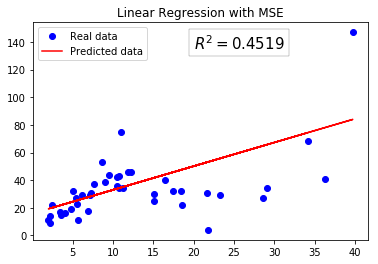

In [8]:
r2 = util.r_squared(data,w,b)
util.plot_line(data, w, b, "Linear Regression with MSE", r2)

### O código acima pode ser melhorado. 

Podemos encapsular os hyper parametros numa classe. Assim como o modelo de regressão linear.

In [7]:
class Config():
    """
    Class to hold all model hyperparams.
    :type learning_rate: float
    :type delta: float
    :type huber: boolean
    :type num_epochs: int
    :type show_epoch: int
    :type log_path: None or str
    """
    def __init__(self,
                 learning_rate=0.001,
                 delta=1.0,
                 huber=False,
                 num_epochs=101,
                 show_epoch=10,
                 log_path=None):
        self.learning_rate = learning_rate
        self.delta = delta
        self.huber = huber
        self.num_epochs = num_epochs
        self.show_epoch = show_epoch
        if log_path is None:
            self.log_path = util.get_log_path()
        else:
            self.log_path = log_path

In [8]:
class LinearRegression:
    """
    Class for the linear regression model
    
    :type config: Config
    """
    def __init__(self, config):
        self.learning_rate = config.learning_rate
        self.delta = config.delta
        self.huber = config.huber
        self.log_path = config.log_path
        self.build_graph()

    def create_placeholders(self):
        """
        Method for creating placeholders for input X (number of fire)
        and label Y (number of theft).
        """
        self.number_fire = tf.placeholder(tf.float32, shape=[], name="X")
        self.number_theft = tf.placeholder(tf.float32, shape=[], name="Y")

    def create_variables(self):
        """
        Method for creating weight and bias variables.
        """
        with tf.name_scope("Weights"):
            self.weight = tf.get_variable("w", dtype=tf.float32, initializer=0.)
            self.bias = tf.get_variable("b", dtype=tf.float32, initializer=0.)

    def create_summaries(self):
        """
        Method to create the histogram summaries for all variables
        """
        tf.summary.histogram('weights_summ', self.weight)
        tf.summary.histogram('bias_summ', self.bias)

    def create_prediction(self):
        """
        Method for creating the linear regression prediction.
        """
        with tf.name_scope("linear-model"):
            self.prediction = (self.number_fire * self.weight) + self.bias

    def create_MSE_loss(self):
        """
        Method for creating the mean square error loss function.
        """
        with tf.name_scope("loss"):
            self.loss = tf.square(self.prediction - self.number_theft)
            tf.summary.scalar("loss", self.loss)

    def create_Huber_loss(self):
        """
        Method for creating the Huber loss function.
        """
        with tf.name_scope("loss"):
            residual = tf.abs(self.prediction - self.number_theft)
            condition = tf.less(residual, self.delta)
            small_residual = 0.5 * tf.square(residual)
            large_residual = self.delta * residual - 0.5 * tf.square(self.delta)
            self.loss = tf.where(condition, small_residual, large_residual)
            tf.summary.scalar("loss", self.loss)

    def create_optimizer(self):
        """
        Method to create the optimizer of the graph
        """
        with tf.name_scope("optimizer"):
            opt = tf.train.GradientDescentOptimizer(self.learning_rate)
            self.optimizer = opt.minimize(self.loss)

    def build_graph(self):
        """
        Method to build the computation graph in tensorflow
        """
        self.graph = tf.Graph()
        with self.graph.as_default():
            self.create_placeholders()
            self.create_variables()
            self.create_summaries()
            self.create_prediction()
            if self.huber:
                self.create_Huber_loss()
            else:
                self.create_MSE_loss()
            self.create_optimizer()

Nesse modelo definimos dois tipos de função de erro. Uma delas é chamada de [Huber loss](https://en.wikipedia.org/wiki/Huber_loss).

Relembrando a função:

   
- $L_{\delta}(y,f(x)) =  \frac{1}{2}(y-f(x))^{2}$ se $|y-f(x)|\leq \delta$

- $L_{\delta}(y,f(x)) =  \delta|y-f(x)| -\frac{1}{2}\delta^{2}$ caso contrário 


In [9]:
def run_training(model, config, data, verbose=True):
    """
    Function to train the linear regression model

    :type model: LinearRegression
    :type config: Config
    :type data: np array
    :type verbose: boolean
    :rtype total_loss: float
    :rtype w: float
    :rtype b: float
    """
    num_samples = data.shape[0]
    num_epochs = config.num_epochs
    show_epoch = config.show_epoch
    log_path = model.log_path
    with tf.Session(graph=model.graph) as sess:
        if verbose:
            print('Start training\n')
        # functions to write the tensorboard logs
        summary_writer = tf.summary.FileWriter(log_path,sess.graph)
        all_summaries = tf.summary.merge_all()
        # initializing variables
        tf.global_variables_initializer().run()
        step = 0
        for i in range(num_epochs): # run num_epochs epochs
            total_loss = 0
            for x, y in data:
                step += 1
                
                feed_dict = {model.number_fire: x,
                             model.number_theft: y}
                
                _,loss,summary,w,b = sess.run([model.optimizer, # run optimizer to perform minimization
                                               model.loss,
                                               all_summaries,
                                               model.weight,
                                               model.bias], feed_dict=feed_dict)

                #writing the log
                summary_writer.add_summary(summary,step)
                summary_writer.flush()
                
                total_loss += loss
            if i % show_epoch == 0:
                print("\nEpoch {0}: {1}".format(i, total_loss/num_samples))
    if verbose:
        print("\n========= For TensorBoard visualization type ===========")
        print("\ntensorboard  --logdir={}\n".format(log_path))
    return total_loss,w,b

In [11]:
my_config = Config()
my_model = LinearRegression(my_config)
l,w,b = run_training(my_model, my_config, data)

Start training


Epoch 0: 2069.6319333978354

Epoch 10: 1924.5930823644712

Epoch 20: 1773.1024853109072

Epoch 30: 1666.1935385839038

Epoch 40: 1589.668056331575

Epoch 50: 1534.211797797609

Epoch 60: 1493.600210891061

Epoch 70: 1463.5996563179153

Epoch 80: 1441.2782130186733

Epoch 90: 1424.5748210840281

Epoch 100: 1412.0180716720365

========= For TensorBoard visualization type ===========

tensorboard  --logdir=./graphs/05-10-2017_22-23-52



## [Tensorboard](https://www.tensorflow.org/get_started/summaries_and_tensorboard) é uma ótima ferramenta de visualização. 

Podemos ver o grafo de computação e ver certas metrícas ao longo do treinamento

In [13]:
# !tensorboard  --logdir=